# Imports

In [1]:
import numpy as np
from pipython import GCSDevice
import traceback
from time import sleep
# from PyQt5.QtWidgets import QApplication
# from bcars_microscope import dark_style_sheet as stylesheet
from bcars_microscope.andor_ccd import AndorNewton970
from pyAndorSDK2 import atmcd_errors

err_codes = atmcd_errors.Error_Codes

import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'none'

from scipy.interpolate import interp1d

from esp301 import ESP301
from pi_nano_stage import NanoStage
from pi_micro_stage import MicroStage


In [2]:
ideal_step_size = 40e-6 * 1000  # m to mm

# From p 59 (or 55) of the C867 manual
# maximum velocity = Stepsize * 20 kHz / 2
velocity = ideal_step_size/0.0055  # mm/s
assert velocity < ideal_step_size * 20e3/2, 'Velocity is too fast: {}. Maximum: {}'.format(velocity, ideal_step_size * 20e3/2)

exposure_time = 0.0035
print('Velocity: {:.2f} mm/s'.format(velocity))
real_step_size = velocity * exposure_time
print('Ideal step size: {:.2f} um. Real step size: {:.2f} um'.format(ideal_step_size*1000, real_step_size*1000))

x_start = 12.5
x_end = 13.5
est_x_steps = int((np.abs(x_end - x_start)/1) / real_step_size)

y_start = 12.5
y_end = 13.5
y_delta = ideal_step_size
# y_steps = est_x_steps
# y_steps = 3
y_vec = np.arange(y_start, y_end, y_delta)
y_steps = y_vec.size

x_ideal_vec = np.linspace(x_start, x_end, int(est_x_steps))
print('Image shape: {}'.format((y_steps, x_ideal_vec.size)))
print('Estimated Time: {:.2f} minutes'.format(np.multiply(*(y_steps, x_ideal_vec.size))*(exposure_time+0.002)/60))

Velocity: 7.27 mm/s
Ideal step size: 40.00 um. Real step size: 25.45 um
Image shape: (25, 39)
Estimated Time: 0.09 minutes


# Initialize Devices

In [3]:
devices = {}
devices['CCD'] = None
devices['MicroStage'] = None
devices['NanoStage'] = None
devices['running'] = False

In [5]:
try:
    print('Initialize CCD')
    devices['CCD'] = AndorNewton970(settings_kwargs={'exposure_time':exposure_time, 'trigger_mode':'INTERNAL'})
    devices['CCD'].init_sdk()
    devices['CCD'].init_camera()
except Exception:
    print('Initialize CCD: Failed')
    print(traceback.format_exc())
else:
    print('Initialize CCD: Success')

Initialize CCD
Initialize SDK 20002: DRV_SUCCESS
Cooler ON: 20002: DRV_SUCCESS
Set temperature: -70 -- 20002: DRV_SUCCESS
Fan Mode: Full -- 20002: DRV_SUCCESS
Set Acquisition Mode: RUN_TILL_ABORT -- 20002: DRV_SUCCESS
Set Amplifier: 1 -- 20002: DRV_SUCCESS
Set AD Channel: 1 -- 20002: DRV_SUCCESS
Set Horizontal Shift Speed: 0 -- 20002: DRV_SUCCESS
Number of Gains: 3
Set Pre-Amp Gain: 2 -- 20002: DRV_SUCCESS
Set Baseline Clamping: True -- 20002: DRV_SUCCESS
Set Vertical Shift Speed: 0 -- 20002: DRV_SUCCESS
Set Vertical Shift Ampltiude: 0 -- 20002: DRV_SUCCESS
Set Fast External Trigger: ON -- 20002: DRV_SUCCESS
Set Exposure Time: 0.0035 -- 20002: DRV_SUCCESS
Frame Transfer Mode: OFF -- 20002: DRV_SUCCESS
Shutter Mode: 1 -- 20002: DRV_SUCCESS
Set Image Flip: OFF, OFF -- 20002: DRV_SUCCESS
Read Mode: 0 -- 20002: DRV_SUCCESS
Detector Size: (200, 1600)
Set Image Dimensions: 20002: DRV_SUCCESS
ReadOut Time: 0.001710 sec
Exposure Time: 0.0035 sec
Accumulate Time: 0.0035 sec
Kinetic Time: 0.0035

In [4]:
try:
    print('Initialize Microstage')
    devices['MicroStage'] = MicroStage()
    devices['MicroStage'].open()
except:
    print('Initialize Microstage: Failed')
    print(traceback.format_exc())
else:
    print('Initialize Microstage: Success')

Initialize Microstage
INIT!!
Opening device: PI C-867 Piezomotor Controller SN 0111036765
Opening succeeded
Initialize Microstage: Success


In [6]:
try:
    print('Initialize Nanostage')
    devices['NanoStage'] = NanoStage()
    devices['NanoStage'].open()
except:
    print('Initialize Nanostage: Failed')
    print(traceback.format_exc())
else:
    print('Initialize Nanostage: Success')
    


Initialize Nanostage
Opening device: PI E-517 Display and Interface SN 0114071272
Opening succeeded
Initialize Nanostage: Success


In [7]:

try:
    print('Initialize Time delay')
    devices['DelayStage'] = ESP301(com_port='COM9')
    devices['DelayStage'].open()
except:
    print('Initialize Time delay: Failed')
    print(traceback.format_exc())
else:
    print('Initialize Time delay: Success')
    
    

Initialize Time delay
Opening device: ESP 301 Stage
Opening succeeded
Initialize Time delay: Success


# Pre-Scan

In [8]:
print('Time per spectrum: {} s'.format(devices['CCD'].net_acquisition_time))
print(devices['MicroStage'].sdk.qIDN())
print(devices['MicroStage'].sdk.qPOS())

# ret = devices['MicroStage'].VEL([1,2], values=[velocity, velocity])
devices['MicroStage'].set_velocity({'1':velocity, '2':velocity})
print('MicroStage velocity: {}'.format(devices['MicroStage'].get_velocity()))
devices['CCD'].sdk.PrepareAcquisition()

Time per spectrum: 0.006919999982267618 s
(c)2010 Physik Instrumente(PI) Karlsruhe, C-867.260,0,1.2.0.1

OrderedDict([('1', 13.4985), ('2', 13.248)])
MicroStage velocity: OrderedDict([('1', 7.2725), ('2', 7.2725)])


20002

# Scan

In [9]:
list_num_imgs = []
img_stack = []
tot_pos_stack = []
tot_n_img_stack = []
data = []

for num in range(y_steps):
    pos_stack = []
    n_img_stack = [0]
    # devices['CCD'].sdk.PrepareAcquisition()
    # ret = devices['MicroStage'].MOV([1,2], values=[x_start, y_vec[num]])
    devices['MicroStage'].set_position({devices['MicroStage'].axis_to_num['X']: x_start, 
                                        devices['MicroStage'].axis_to_num['Y']:y_vec[num]})
    
    while devices['MicroStage'].is_moving():
        sleep(0.1)
    print('Ready for line scan')
    pos_stack.append(devices['MicroStage'].get_position())
    devices['CCD'].start_acquisition()
    ret = devices['MicroStage'].set_position({devices['MicroStage'].axis_to_num['X']:x_end})

    while devices['MicroStage'].is_moving():
        sleep(0.01)
        pos_stack.append(devices['MicroStage'].get_position())
        n_img_stack.append(devices['CCD'].get_num_new_images()[1])
        
    devices['CCD'].stop_acquisition()
    pos_stack.append(devices['MicroStage'].get_position())
    n_img_stack.append(devices['CCD'].get_num_new_images()[1])
    print('============= {} / {} ============'.format(num+1, y_steps))

    ret_code, n_images, first_img, last_img = devices['CCD'].get_num_new_images()
    print('New Images: {}'.format(n_images))

    # est_n_images = (np.abs(x_end - x_start)/1) / devices['CCD'].net_acquisition_time

    print('Estimated number of images: {}'.format(est_x_steps))
    print('Image uncertainty (100 ms): {}'.format(100e-3 / devices['CCD'].sdk.GetAcquisitionTimings()[1] ))
    list_num_imgs.append(devices['CCD'].get_num_new_images()[1])


    (ret_code, arr, validfirst, validlast) = devices['CCD'].get_all_images16()
    arr = arr.reshape((n_images, -1))
    data.append(1*arr)
    # plt.plot(arr.T);
    # plt.show()
    img_stack.append(arr[...,392] - 0*arr[...,360])

    devices['CCD'].free_memory()
    tot_pos_stack.append(pos_stack)
    tot_n_img_stack.append(n_img_stack)
print('N Image List: {}'.format(list_num_imgs))
print('Spatial uncertainty: {} spectra, thus, {} microns'.format(np.max(list_num_imgs) - np.min(list_num_imgs),
                                                                     devices['CCD'].sdk.GetAcquisitionTimings()[1] * (np.max(list_num_imgs) - np.min(list_num_imgs)) * 1000))

Ready for line scan
Starting Acquisition: 20002 -- DRV_SUCCESS
Aborting Acquisition: 20002 -- DRV_SUCCESS
============= 1 / 25 ============
New Images: 126
Estimated number of images: 39
Image uncertainty (100 ms): 28.571428571428573
Free Internal Memory: 20002 -- DRV_SUCCESS
Ready for line scan
Starting Acquisition: 20002 -- DRV_SUCCESS
Aborting Acquisition: 20002 -- DRV_SUCCESS
============= 2 / 25 ============
New Images: 144
Estimated number of images: 39
Image uncertainty (100 ms): 28.571428571428573
Free Internal Memory: 20002 -- DRV_SUCCESS
Ready for line scan
Starting Acquisition: 20002 -- DRV_SUCCESS
Aborting Acquisition: 20002 -- DRV_SUCCESS
============= 3 / 25 ============
New Images: 138
Estimated number of images: 39
Image uncertainty (100 ms): 28.571428571428573
Free Internal Memory: 20002 -- DRV_SUCCESS
Ready for line scan
Starting Acquisition: 20002 -- DRV_SUCCESS
Aborting Acquisition: 20002 -- DRV_SUCCESS
============= 4 / 25 ============
New Images: 168
Estimated num

# Plotting

Text(0, 0.5, 'Y (mm)')

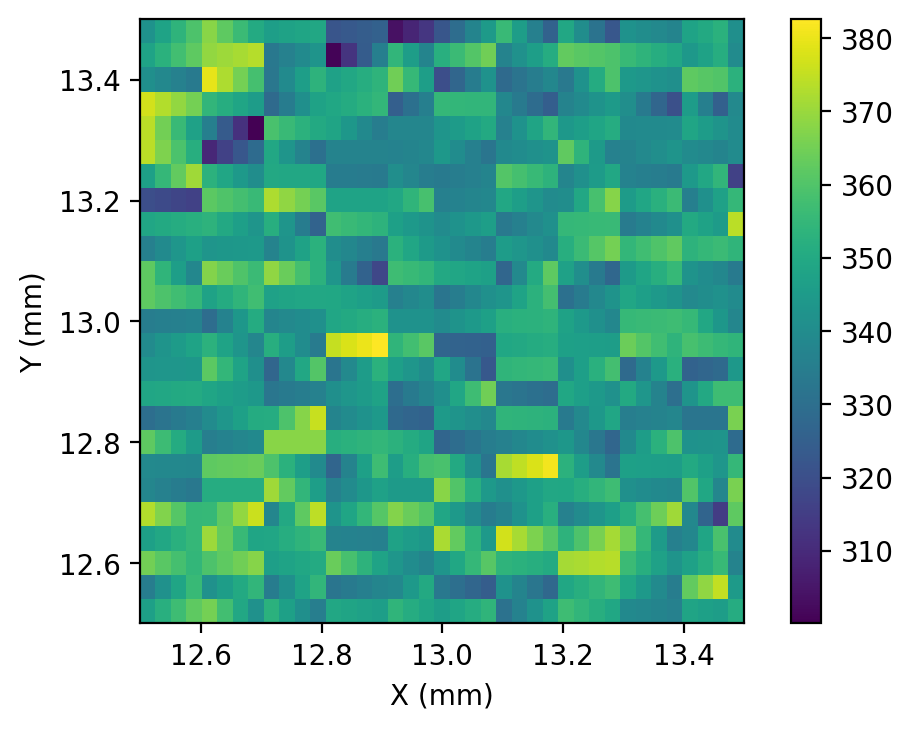

In [13]:
assert len(tot_pos_stack) == len(tot_n_img_stack)


img_interp = np.zeros((y_steps, int(est_x_steps)))

all_xs = []
all_ys = []
plt.figure(dpi=200)
for num in range(y_steps):
    x_pos_vec = np.array([p[devices['MicroStage'].axis_to_num['X']] for p in tot_pos_stack[num]])
    all_xs.extend(x_pos_vec.tolist())
    y_pos_vec = np.array([p[devices['MicroStage'].axis_to_num['Y']] for p in tot_pos_stack[num]])
    all_ys.extend(np.unique(y_pos_vec).tolist())
    n_img_vec = np.array(tot_n_img_stack[num])

    intfcn = interp1d(n_img_vec, x_pos_vec, kind='linear')
#     plt.scatter(intfcn(np.arange(img_stack[num].size)), y_pos_vec.mean()*np.ones((img_stack[num].size)), c=img_stack[num], marker='s', s=1)
    
    # Rounded so I don't have to deal with extrapolation outside of the interp range by some fraction
    int_fcn_intensity = interp1d(np.round(intfcn(np.arange(img_stack[num].size)),1), img_stack[num], bounds_error=True)
    
    
#     plt.scatter(x_ideal_vec, y_pos_vec.mean()*np.ones((x_ideal_vec.size)), c=int_fcn_intensity(x_ideal_vec), marker='s', s=1)
    img_interp[num, :] = int_fcn_intensity(x_ideal_vec)

plt.imshow(img_interp, extent=[x_start, x_end, y_start, y_end])  # IMPORTANT: Need to have origin=lower
plt.colorbar()
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
# plt.title('Raw BCARS Image of Small\nUnilaminar Vesicle (Aggregates)')b

(126, 1600)

In [35]:
tot_pos_stack[num][0][devices['MicroStage'].axis_to_num['Y']] for i in range(y_steps)

12.499

In [ ]:
plt.scatter()

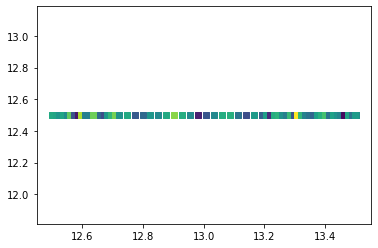

In [43]:
assert len(tot_pos_stack) == len(tot_n_img_stack)

for num in range(y_steps):
    x_sampled = np.array([p[devices['MicroStage'].axis_to_num['X']] for p in tot_pos_stack[num]])
    n_img = data[num].shape[0]
    intfcn = interp1d(np.array(tot_n_img_stack[num]), x_sampled, kind='linear')
    x_pos_interp = intfcn(np.arange(n_img))
    y_pos = tot_pos_stack
    # plt.plot(x_sampled)
    plt.scatter(x_pos_interp, [y_vec[num]]*n_img, c=img_stack[num], marker='s')
# img_interp = np.zeros((y_steps, int(est_x_steps)))

# all_xs = []
# all_ys = []
# plt.figure(dpi=200)
# for num in range(y_steps):
#     x_pos_vec = np.array([p[devices['MicroStage'].axis_to_num['X']] for p in tot_pos_stack[num]])
#     all_xs.extend(x_pos_vec.tolist())
#     y_pos_vec = np.array([p[devices['MicroStage'].axis_to_num['Y']] for p in tot_pos_stack[num]])
#     all_ys.extend(np.unique(y_pos_vec).tolist())
#     n_img_vec = np.array(tot_n_img_stack[num])

#     intfcn = interp1d(n_img_vec, x_pos_vec, kind='linear')
# #     plt.scatter(intfcn(np.arange(img_stack[num].size)), y_pos_vec.mean()*np.ones((img_stack[num].size)), c=img_stack[num], marker='s', s=1)
    
#     # Rounded so I don't have to deal with extrapolation outside of the interp range by some fraction
#     int_fcn_intensity = interp1d(np.round(intfcn(np.arange(img_stack[num].size)),1), img_stack[num], bounds_error=True)
    
    
# #     plt.scatter(x_ideal_vec, y_pos_vec.mean()*np.ones((x_ideal_vec.size)), c=int_fcn_intensity(x_ideal_vec), marker='s', s=1)
#     img_interp[num, :] = int_fcn_intensity(x_ideal_vec)

# plt.imshow(img_interp, extent=[x_start, x_end, y_start, y_end])  # IMPORTANT: Need to have origin=lower
# plt.colorbar()
# plt.xlabel('X (mm)')
# plt.ylabel('Y (mm)')
# # plt.title('Raw BCARS Image of Small\nUnilaminar Vesicle (Aggregates)')

# Close Devices

In [15]:
devices['DelayStage'].close()
devices['NanoStage'].close()
devices['MicroStage'].close()
devices['CCD'].free_memory()
ret_code = devices['CCD'].shutdown()
print("Function Shutdown returned {}: {}".format(ret_code, err_codes(ret_code).name))

print('Closing Connection...')

Closing device: PI E-517 Display and Interface SN 0114071272
Closing succeeded
Closing device: PI C-867 Piezomotor Controller SN 0111036765
Closing succeeded
Free Internal Memory: 20002 -- DRV_SUCCESS
Shutting Down CCD
Function Shutdown returned 20002: DRV_SUCCESS
Closing Connection...


# SCRAP Below

In [31]:
raise Exception

Exception: 

Text(0, 0.5, 'Y (mm)')

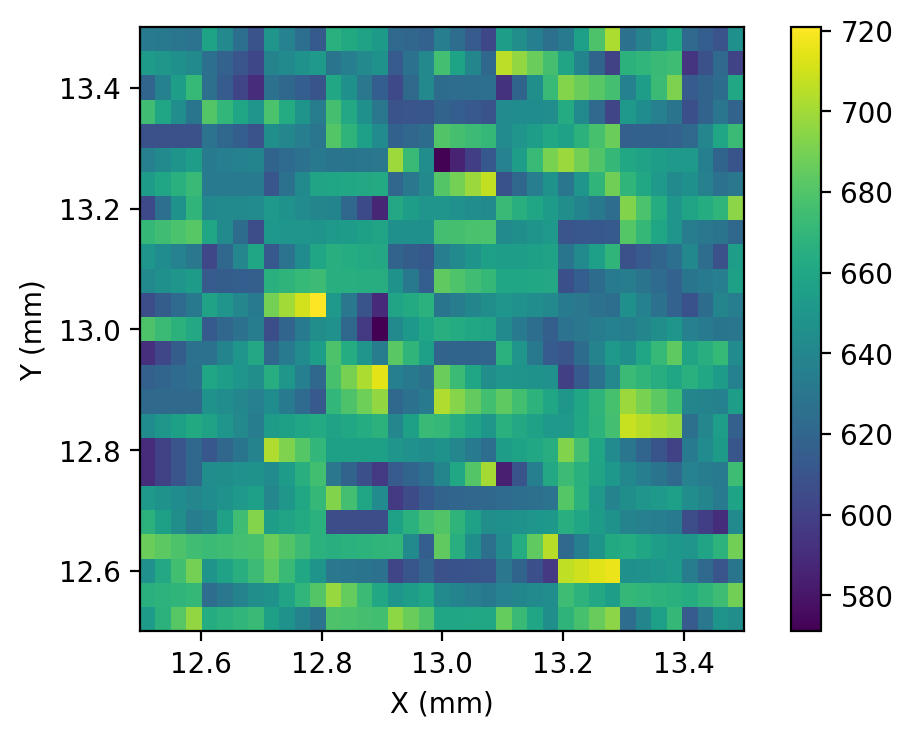

In [11]:
assert len(tot_pos_stack) == len(tot_n_img_stack)


img_interp = np.zeros((y_steps, int(est_x_steps)))

all_xs = []
all_ys = []
plt.figure(dpi=200)
for num in range(y_steps):
    x_pos_vec = np.array([p['1'] for p in tot_pos_stack[num]])
    all_xs.extend(x_pos_vec.tolist())
    y_pos_vec = np.array([p['2'] for p in tot_pos_stack[num]])
    all_ys.extend(np.unique(y_pos_vec).tolist())
    n_img_vec = np.array(tot_n_img_stack[num])

    intfcn = interp1d(n_img_vec, x_pos_vec, kind='linear')
#     plt.scatter(intfcn(np.arange(img_stack[num].size)), y_pos_vec.mean()*np.ones((img_stack[num].size)), c=img_stack[num], marker='s', s=1)
    
    # Rounded so I don't have to deal with extrapolation outside of the interp range by some fraction
    int_fcn_intensity = interp1d(np.round(intfcn(np.arange(img_stack[num].size)),1), img_stack[num], bounds_error=True)
    
    
#     plt.scatter(x_ideal_vec, y_pos_vec.mean()*np.ones((x_ideal_vec.size)), c=int_fcn_intensity(x_ideal_vec), marker='s', s=1)
    img_interp[num, :] = int_fcn_intensity(x_ideal_vec)

plt.imshow(img_interp, extent=[x_start, x_end, y_start, y_end])  # IMPORTANT: Need to have origin=lower
plt.colorbar()
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
# plt.title('Raw BCARS Image of Small\nUnilaminar Vesicle (Aggregates)')

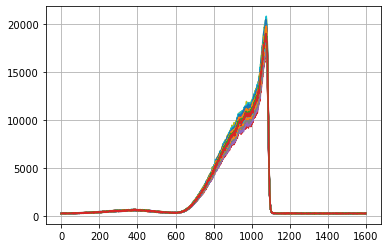

In [12]:
fig, ax = plt.subplots()
plt.plot(arr.T)
ax.grid(True)

Text(0.5, 1.0, 'Raw BCARS Image of Small\nUnilaminar Vesicle (Aggregates)')

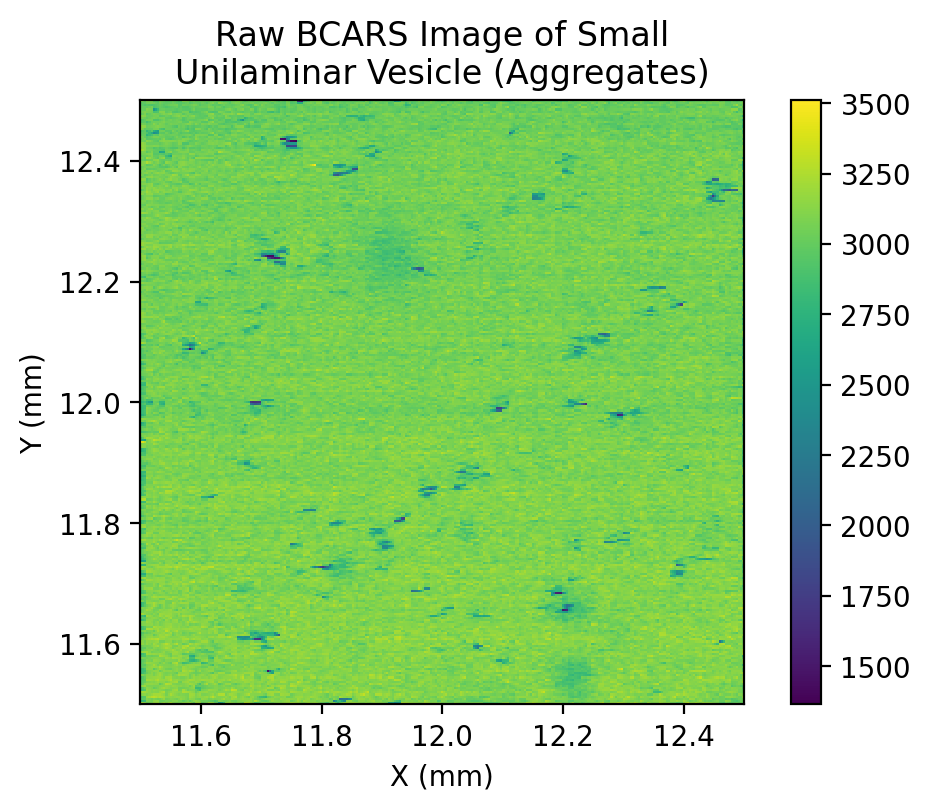

In [172]:
assert len(tot_pos_stack) == len(tot_n_img_stack)


img_interp = np.zeros((y_steps, int(est_x_steps)))

all_xs = []
plt.figure(dpi=200)
for num in range(y_steps):
    x_pos_vec = np.array([p['1'] for p in tot_pos_stack[num]])
    all_xs.extend(x_pos_vec.tolist())
    y_pos_vec = np.array([p['2'] for p in tot_pos_stack[num]])
    n_img_vec = np.array(tot_n_img_stack[num])

    intfcn = interp1d(n_img_vec, x_pos_vec, kind='linear')
#     plt.scatter(intfcn(np.arange(img_stack[num].size)), y_pos_vec.mean()*np.ones((img_stack[num].size)), c=img_stack[num], marker='s', s=1)
    
    # Rounded so I don't have to deal with extrapolation outside of the interp range by some fraction
    int_fcn_intensity = interp1d(np.round(intfcn(np.arange(img_stack[num].size)),2), img_stack[num], bounds_error=True)
    
    
#     plt.scatter(x_ideal_vec, y_pos_vec.mean()*np.ones((x_ideal_vec.size)), c=int_fcn_intensity(x_ideal_vec), marker='s', s=1)
    img_interp[num, :] = int_fcn_intensity(x_ideal_vec)
plt.imshow(img_interp, interpolation='none', extent=[x_start, x_end, y_start, y_end])
plt.colorbar()
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Raw BCARS Image of Small\nUnilaminar Vesicle (Aggregates)')

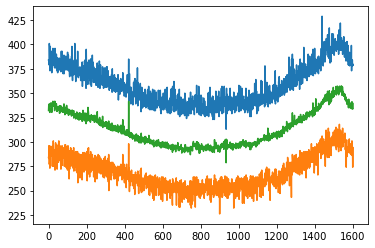

In [27]:
plt.plot(arr.max(axis=0))
plt.plot(arr.min(axis=0))
plt.plot(arr.mean(axis=0))
# plt.axis(xmax=392, xmin=360, ymax=2000)

In [128]:
int_fcn_intensity(11.51)

array(5851.6)

In [123]:
int_fcn_intensity(x_ideal_vec.min())

ValueError: A value in x_new is below the interpolation range.

array([5965.        , 5853.25352113, 5937.11267606, 5776.76056338,
       5881.81690141, 5839.22535211, 5941.01408451, 5931.54929577,
       5697.26760563, 5882.04225352, 5817.67605634, 5666.26760563,
       5913.04225352, 5727.3943662 , 5949.05633803, 5695.90140845,
       5702.57746479, 5743.53521127, 5771.32468495, 5724.62342476,
       5834.21126761, 5860.31060044, 5820.36397331, 5841.8613788 ,
       5826.64121572, 5740.00667161, 5604.32690882, 5548.7301705 ,
       5595.42920682, 5635.01853225, 5657.03854707, 5840.87842847,
       5845.56338028, 5807.38324685, 5790.68939956, 5801.80874722,
       5767.47368421, 5730.76204596, 5721.31060044, 5675.3506301 ,
       5643.7079318 , 5637.80948851, 5671.90882135, 5807.69787144,
       5730.55681457, 5755.29429207, 5877.14995235, 5720.12146564,
       5757.95552261, 5803.43556073, 5827.55046066, 5959.92957746,
       5909.89251297, 5824.40294398, 5873.2335063 , 5816.98358572,
       5752.85883723, 5763.93264852, 5882.90363232, 5695.96812

In [33]:
pos_vec

array([0.9985, 0.9985, 1.0575, 1.123 , 1.1905, 1.257 , 1.339 , 1.4045,
       1.486 , 1.5525, 1.6175, 1.6825, 1.7615, 1.8245, 1.8905, 1.956 ,
       2.021 , 2.088 , 2.17  , 2.2485, 2.313 , 2.392 , 2.458 , 2.5385,
       2.6175, 2.683 , 2.7615, 2.8255, 2.8915, 2.9715, 3.05  , 3.1145,
       3.178 , 3.2425, 3.3075, 3.372 , 3.435 , 3.499 , 3.5635, 3.626 ,
       3.6905, 3.7555, 3.8195, 3.884 , 3.948 , 4.012 , 4.078 , 4.14  ,
       4.206 , 4.269 , 4.3325, 4.3965, 4.46  , 4.525 , 4.5885, 4.653 ,
       4.7315, 4.797 , 4.86  , 4.9245, 4.996 , 5.003 , 5.0035, 5.    ,
       5.0005])

In [40]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

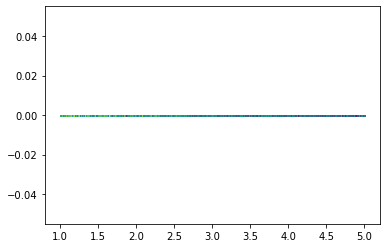

1212